In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import numpy as np

import keras
import tensorflow as tf 
from keras.layers import Conv2D, Dense
from keras.layers import concatenate, add
from keras.layers import BatchNormalization, Activation, PReLU
from keras.layers import Input, Flatten, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras.backend as K
from keras.applications.vgg19 import VGG19

from shutil import rmtree

from batch_generator import COCOBatchGenerator
from bsd100_callback import BSD100_Evaluator
from utils import print_available_devices, deprocess_HR, deprocess_LR

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [ ]:
if tf.test.is_built_with_cuda():
    data_format = 'channels_first'
    keras.backend.set_image_data_format('channels_first')
else:
    data_format = 'channels_last'
    keras.backend.set_image_data_format('channels_last')

In [3]:
print("Keras : ", keras.__version__)
print("\t data_format : ", keras.backend.image_data_format())
print("Tensorflow : ", tf.__version__)
print_available_devices()

Keras :  2.1.6
Tensorflow :  1.8.0
Device : /device:CPU:0
	 type : CPU
	 desc :

Device : /device:GPU:0
	 type : GPU
	 desc :device: 0, name: GeForce GTX 1070, pci bus id: 0000:02:00.0, compute capability: 6.1



## Parameters

In [4]:
B = 16 # number of residual block

batch_size = 16
target_size = (96,96)
downscale_factor = 4

num_steps = 1e5
steps_per_epoch = 5000
epochs = int(num_steps//steps_per_epoch)

# axis used in Parametric ReLU !
shared_axis = [1,2] if data_format == 'channels_last' else [2,3]

# axis for Batch Normalization
axis = -1 if data_format == 'channels_last' else 1

print('epochs = ', epochs)

epochs =  100


## Build the Generator

In [5]:
# build a residual block
def res_block(inputs):
    x = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation=None, use_bias=False)(inputs)
    x = BatchNormalization(axis=axis)(x)
    x = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axis)(x)
    x = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation=None, use_bias=False)(x)
    x = BatchNormalization(axis=axis)(x)
    return add([x, inputs])

# build an upscale block
# PixelShuffler is replaced by an UpSampling2D layer (nearest upsampling)

def up_block(x):
    x = Conv2D(256, kernel_size=(3,3), strides=(1,1) , padding='same', activation=None, use_bias=False)(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axis)(x)
    return x

In [6]:
input_generator = Input(shape=(None, None, 3) if data_format=='channels_last' else (3, None, None), 
                        name='input_generator')

x = Conv2D(filters=64, kernel_size=(9,9),
           strides=(1,1), padding='same',
           activation=None)(input_generator)

x_input_res_block = PReLU(alpha_initializer='zeros',
                          alpha_regularizer=None,
                          alpha_constraint=None,
                          shared_axes=shared_axis)(x)

x = x_input_res_block

# add B residual blocks 
for i in range(B):
    x = res_block(x)

x = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation=None, use_bias=False)(x)
x = BatchNormalization(axis=axis)(x)

# skip connection
x = add([x, x_input_res_block])

# two upscale blocks
x = up_block(x)
x = up_block(x)

# final conv layer : activated with tanh -> pixels in [-1, 1]
output_generator = Conv2D(3, kernel_size=(9,9), 
                          strides=(1,1), activation='tanh',
                          use_bias=False, padding='same')(x)

generator = Model(inputs=input_generator, outputs=output_generator)

In [7]:
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_generator (InputLayer)    (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   15616       input_generator[0][0]            
__________________________________________________________________________________________________
p_re_lu_1 (PReLU)               (None, 64, 64, 64)   262144      conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 64)   36864       p_re_lu_1[0][0]                  
__________________________________________________________________________________________________
batch_norm

### Add VGG19 as Perceptual Loss

In [8]:
def preproces_vgg(x):
    # scale from [-1,1] to [0, 255]
    x += 1.
    x *= 127.5
    
    # RGB -> BGR
    if data_format == 'channels_last':
        x = x[..., ::-1]
    else:
        x = x[:,::-1,:,:]
    
    # apply Imagenet preprocessing : BGR mean
    mean = [103.939, 116.778, 123.68]
    _IMAGENET_MEAN = K.constant(-np.array(mean))
    x = K.bias_add(x, K.cast(_IMAGENET_MEAN, K.dtype(x)))
    
    return x

In [9]:
def vgg_loss(y_true, y_pred):
    # load pretrained VGG
    vgg19 = VGG19(include_top=False,
                  input_shape=target_size+(3,) if data_format=='channels_last' else (3,)+target_size, 
                  weights='imagenet')
    vgg19.trainable = False
    for l in vgg19.layers:
        l.trainable = False
    
    # create a model that ouputs the features from level 'block2_conv2'
    features_extractor = Model(inputs=vgg19.input, outputs=vgg19.get_layer("block2_conv2").output)
    
    # compute the features, y_pred and y_true are tensors scaled in [-1, 1]
    # it needs te be rescaled and shifted to respect VGG preprocessing strategy
    features_pred = features_extractor(preproces_vgg(y_pred))
    features_true = features_extractor(preproces_vgg(y_true))
    
    # adding the scaling factor (to have similar values as with MSE within image space)
    return 0.006*K.mean(K.square(features_pred - features_true), axis=-1)

In [10]:
opt = Adam(lr=1e-4, beta_1=0.9)
generator.compile(loss=vgg_loss, optimizer=opt)

## Training data

In [11]:
batch_gen = COCOBatchGenerator(directory='data/COCO/train2014/',
                               batch_size=batch_size,
                               downscale_factor=4,
                               target_size=target_size,
                               shuffle=True,
                               crop_mode='fixed_size',
                               color_mode='rgb',
                               data_format=data_format)

Found 82783 images


(4, 64, 64, 3)
(4, 256, 256, 3)


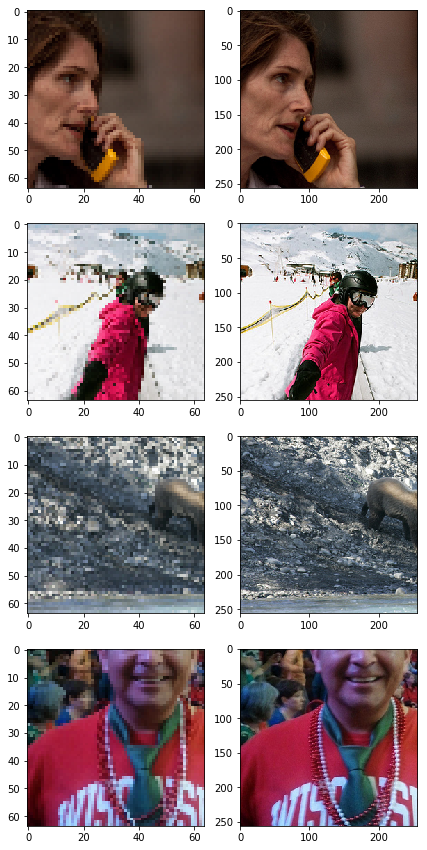

In [12]:
batch_LR, batch_HR = batch_gen.next()
print(batch_LR.shape)
print(batch_HR.shape)

if data_format == 'channels_first':
    batch_LR = np.transpose(batch_LR, (0,2,3,1))
    batch_HR = np.transpose(batch_HR, (0,2,3,1))

# LR| HR 
fig, axes = plt.subplots(4, 2, figsize=(7, 15))
for i in range(4):
    axes[i, 0].imshow(deprocess_LR(batch_LR[i]).astype(np.uint8))
    axes[i, 1].imshow(deprocess_HR(batch_HR[i]).astype(np.uint8))

## Train 'generator' with MSE Loss

In [13]:
if os.path.isdir('checkpoints/SRResNet-VGG54/'):
    rmtree('checkpoints/SRResNet-VGG54/')
os.mkdir('checkpoints/SRResNet-VGG54/')

In [14]:
checkpoint = ModelCheckpoint(filepath='checkpoints/SRResNet-VGG54/weights.{epoch:02d}-{loss:.2f}.hdf5',
                             monitor='loss',
                             save_weights_only=True,
                             period=10,
                             verbose=2)

best_checkpoint = ModelCheckpoint(filepath='checkpoints/SRResNet-VGG54/best_weights.hdf5',
                                  monitor='loss',
                                  save_weights_only=True,
                                  save_best_only=True, 
                                  period=1,
                                  verbose=2)

bsd100_callback = BSD100_Evaluator(directory='data/BSD100/',
                                   filepath='checkpoints/SRResNet-VGG54/BSD100/',
                                   downscale_factor=4,
                                   color_mode='rgb',
                                   verbose=1)


bsd100_callback = BSD100_Evaluator(directory='data/BSD100/',
                                   filepath='checkpoints/SRResNet-VGG54/BSD100/',
                                   downscale_factor=4,
                                   color_mode='rgb',
                                   verbose=1,
                                   data_format=data_format,
                                   margin=5)


early_stop = EarlyStopping(monitor='loss',min_delta=0, patience=3, verbose=1, mode='min')


callbacks = [checkpoint, best_checkpoint, bsd100_callback, early_stop]

Found 100 images ...


In [ ]:
%%time

history = generator.fit_generator(batch_gen,
                                  epochs=epochs,
                                  callbacks=callbacks,
                                  steps_per_epoch=steps_per_epoch)

Epoch 1/100
   52/10000 [..............................] - ETA: 1:24:43 - loss: 432.4466

In [ ]:
plt.figure(figsize=(16, 4))
plt.plot(history.history['loss'])
plt.title('training loss')
plt.ylabel('mse [-1, 1]')
plt.xlabel('epoch')
plt.show()

plt.figure(figsize=(16, 4))
plt.plot(bsd100_callback.logs['mse'])
plt.title('validation loss')
plt.ylabel('mse [0, 255]')
plt.xlabel('epoch')
plt.show()

plt.figure(figsize=(16, 4))
plt.plot(bsd100_callback.logs['psnr'])
plt.title('validation PSNR')
plt.ylabel('PSNR (dB)')
plt.xlabel('epoch')
plt.show()